<a href="https://colab.research.google.com/github/mansikulharii/MiniProject---Instagram/blob/main/MiniProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install pandas numpy scikit-learn matplotlib

In [7]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from google.colab import drive
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
import os


drive.mount('/content/drive')


# Load data
data_path = '/content/drive/My Drive/Mini-Project/instagram_data.csv'
data = pd.read_csv(data_path)

# Print original image paths to see their current format
print("Original image paths:")
print(data['image_path'].head())

# Define the base path where images are stored
base_image_path = '/content/drive/My Drive/Mini-Project/insta_data/'

# Clean up the image_path in case it includes unnecessary relative paths
data['image_path'] = data['image_path'].apply(lambda x: os.path.basename(x))  # This takes just the file name, removing any directory structure

# Append the base path to the cleaned image names
data['image_path'] = data['image_path'].apply(lambda x: os.path.join(base_image_path, x))

# Print the corrected paths
print("Corrected image paths:")
print(data['image_path'].head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Original image paths:
0    ../Data/insta_data/0.jpg
1    ../Data/insta_data/2.jpg
2    ../Data/insta_data/4.jpg
3    ../Data/insta_data/6.jpg
4    ../Data/insta_data/8.jpg
Name: image_path, dtype: object
Corrected image paths:
0    /content/drive/My Drive/Mini-Project/insta_dat...
1    /content/drive/My Drive/Mini-Project/insta_dat...
2    /content/drive/My Drive/Mini-Project/insta_dat...
3    /content/drive/My Drive/Mini-Project/insta_dat...
4    /content/drive/My Drive/Mini-Project/insta_dat...
Name: image_path, dtype: object


In [8]:
# Verify the full content of image paths to check for repeated extensions
for path in data['image_path'].head(10):
    print(path)

/content/drive/My Drive/Mini-Project/insta_data/0.jpg
/content/drive/My Drive/Mini-Project/insta_data/2.jpg
/content/drive/My Drive/Mini-Project/insta_data/4.jpg
/content/drive/My Drive/Mini-Project/insta_data/6.jpg
/content/drive/My Drive/Mini-Project/insta_data/8.jpg
/content/drive/My Drive/Mini-Project/insta_data/9.jpg
/content/drive/My Drive/Mini-Project/insta_data/11.jpg
/content/drive/My Drive/Mini-Project/insta_data/19.jpg
/content/drive/My Drive/Mini-Project/insta_data/20.jpg
/content/drive/My Drive/Mini-Project/insta_data/21.jpg


In [9]:
# Check if the files actually exist
data['file_exists'] = data['image_path'].apply(os.path.exists)

# Print paths that do not point to an existing file
print("Paths to non-existent files:")
print(data[data['file_exists'] == False]['image_path'])

# Optionally, you might decide to drop entries where images do not exist
# data = data[data['file_exists'] == True]


Paths to non-existent files:
Series([], Name: image_path, dtype: object)


**DATA PREPROCESSING**
> Data Cleaning

> Feature Engineering

> Numerical Feature Scaling



In [10]:
data.dropna(inplace=True)    #data cleaning

#calculating quantiles for 'likes'
q_low = data['likes'].quantile(0.01)
q_high = data['likes'].quantile(0.99)

#filtering data based on 'likes' quantiles
data = data[(data['likes'] > q_low) & (data['likes'] < q_high)]

#if 'posted_time' column exists before proceeding
if 'posted_time' in data.columns:
  #converting 'posted_time' to datetime if it exists
  data['posted_time'] = pd.to_datetime(data['posted_time'])    #feature engineering

  #extract day of week and hour of the day from timestamp
  data['day_of_week'] = data['posted_time'].dt.dayofweek
  data['hour_of_day'] = data['posted_time'].dt.hour
else:
  #if 'posted_time' is not present
  data['day_of_week'] = 0  # Example: Set a default value
  data['hour_of_day'] = 0   # Example: Set a default value

#scaling the numerical features
scaler = StandardScaler()
data.loc[:, ['follower_count_at_t', 'no_of_comments']] = scaler.fit_transform(data[['follower_count_at_t', 'no_of_comments']])


#verifying the full content of image paths to check for repeated extensions
#for path in data['image_path'].head(10):
#    print(path)


<ipython-input-10-98fea2484dd0>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day_of_week'] = 0  # Example: Set a default value
<ipython-input-10-98fea2484dd0>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hour_of_day'] = 0   # Example: Set a default value


In [11]:
# Print the first few entries of the image_path to understand its content
#print(data['image_path'].head())

#verifying the full content of image paths to check for repeated extensions
for path in data['image_path'].head(10):
    print(path)


/content/drive/My Drive/Mini-Project/insta_data/0.jpg
/content/drive/My Drive/Mini-Project/insta_data/2.jpg
/content/drive/My Drive/Mini-Project/insta_data/4.jpg
/content/drive/My Drive/Mini-Project/insta_data/6.jpg
/content/drive/My Drive/Mini-Project/insta_data/8.jpg
/content/drive/My Drive/Mini-Project/insta_data/9.jpg
/content/drive/My Drive/Mini-Project/insta_data/11.jpg
/content/drive/My Drive/Mini-Project/insta_data/19.jpg
/content/drive/My Drive/Mini-Project/insta_data/20.jpg
/content/drive/My Drive/Mini-Project/insta_data/21.jpg


In [12]:
# Load the model
base_model = VGG16(weights='imagenet', include_top=False)
print("Model loaded.")

# Function to extract features from an image
def extract_features(image_path, model):
    print(f"Trying to load image: {image_path}")  # Ensure this line is uncommented to see the paths
    if not os.path.exists(image_path):
        print(f"File not found: {image_path}")
        return np.zeros((model.output_shape[-1],))  # Using model.output_shape[-1] to match the expected feature size
    try:
        img = image.load_img(image_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        expanded_img_array = np.expand_dims(img_array, axis=0)
        preprocessed_img = preprocess_input(expanded_img_array)
        features = model.predict(preprocessed_img)
        flattened_features = features.flatten()
        return flattened_features
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return np.zeros((model.output_shape[-1],))




# Check a few paths to ensure they're correct
print("Sample image paths:")
print(data['image_path'].head(5))

# Extract features for each image using the actual paths
features_arrays = data['image_path'].apply(lambda x: extract_features(x, base_model))
features_matrix = np.array(features_arrays.tolist())

# Normalizing the target variable (likes) and other numeric features
data['likes_log'] = np.log(data['likes'] + 1)
scaler = StandardScaler()
data[['follower_count_at_t', 'no_of_comments']] = scaler.fit_transform(data[['follower_count_at_t', 'no_of_comments']])

print("Feature extraction and scaling complete.")

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
Trying to load image: /content/drive/My Drive/Mini-Project/insta_data/2871.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
Trying to load image: /content/drive/My Drive/Mini-Project/insta_data/2872.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
Trying to load image: /content/drive/My Drive/Mini-Project/insta_data/2873.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
Trying to load image: /content/drive/My Drive/Mini-Project/insta_data/2877.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
Trying to load image: /content/drive/My Drive/Mini-Project/insta_data/2880.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
Trying to load image: /content/drive/My Drive/Mini-Project/insta_data/2881.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
Trying to load image: /content/drive/My Drive/Mini-Project/insta_data/2882.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
Trying to load image: /content/drive/My Drive/Mini-Project/insta_data/2883.jpg
1/1 ━

**MODEL TRAINING AND EVALUATION**

Mean Squared Error: 9850227975.942173
R^2 Score: 0.6414973731518252


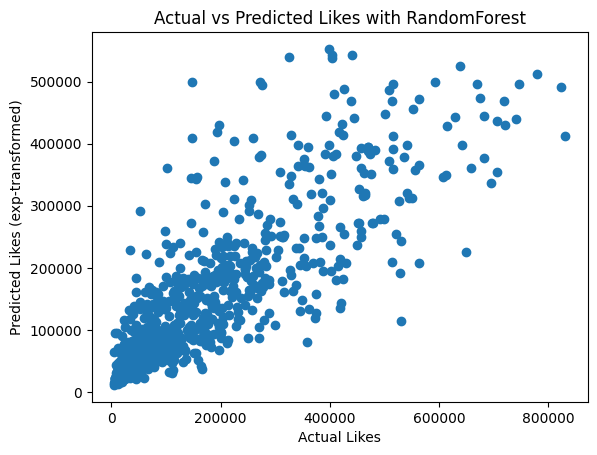

In [13]:
# Prepare the feature set
X_numeric = data[['follower_count_at_t', 'no_of_comments', 't']]  # Update or remove 't' as needed if it's a timestamp
X_combined = np.hstack((X_numeric, features_matrix))  # Combine numeric features with image features

# Prepare target variable
y = data['likes_log']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Initialize and train a RandomForest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_exp = np.exp(y_pred) - 1  # Convert back from log scale to original scale for evaluation

mse = mean_squared_error(np.exp(y_test) - 1, y_pred_exp)
r2 = r2_score(np.exp(y_test) - 1, y_pred_exp)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Visualizing the improved predictions
plt.scatter(np.exp(y_test) - 1, y_pred_exp)
plt.xlabel('Actual Likes')
plt.ylabel('Predicted Likes (exp-transformed)')
plt.title('Actual vs Predicted Likes with RandomForest')
plt.show()
